In [25]:
# Dependencies
#for model-building
from sklearn import (model_selection, 
                     preprocessing, 
                     linear_model, 
                     naive_bayes, 
                     metrics, 
                     svm)
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import (TfidfVectorizer, 
                                             CountVectorizer)
from sklearn import decomposition, ensemble

import pandas as pd
import numpy as np
import xgboost, textblob, string

from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/syntax_error/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/syntax_error/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/syntax_error/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/syntax_error/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Motivation

In recent years, large language models (LLMs) have become increasingly sophisticated, capable of generating text that is difficult to distinguish from human-written text. The topic is not only interesting from an educational point of view, but has implications in business live as well, where AI can be used for writing ads, articles, reviews etc., and could enable plagiarism and replace humans, which can create an even increased unemployement rate and even end professions with long history like journalist, reporter, etc.

This notebook was made for the project of the course BMETE15MF75 at Budapest University of Technology and Economy.

In this notebook we will implement several different approaches to **text classification**. The goal is to successfully identify human written and AI-written (by LLMs) texts. The idea of the project came from the [LLM - Detect AI Generated Text](https://www.kaggle.com/competitions/llm-detect-ai-generated-text) kaggle competition.

## Introduction

In the case of this notebook our focus will be on essays written by middle and high school students, but the idea is quite general, and the pipeline can be easily reconfigured for other types of text as well.

That being said, we will try to build a model to identify which essay was written by middle and high school students, and which was written using a large language model. With the spread of LLMs, many people fear they will replace or alter work that would usually be done by humans. Educators are especially concerned about their impact on students’ skill development, though many remain optimistic that LLMs will ultimately be a useful tool to help students improve their writing skills.

At the forefront of academic concerns about LLMs is their potential to enable plagiarism. LLMs are trained on a massive dataset of text and code, which means that they are able to generate text that is very similar to human-written text. For example, students could use LLMs to generate essays that are not their own, missing crucial learning keystones. Your work on this competition can help identify telltale LLM artifacts and advance the state of the art in LLM text detection. By using texts of moderate length on a variety of subjects and multiple, unknown generative models, we aim to replicate typical detection scenarios and incentivize learning features that generalize across models. (source [kaggle](https://www.kaggle.com/competitions/llm-detect-ai-generated-text))

## Resources

When dealing with natural language processing (NLP), there are a large number of sources that can be used for learning and getting familiar with the topic. We used the following ones in creating this notebook:

1. kaggle, [Explained LLM Model](https://www.kaggle.com/code/zulqarnainali/explained-llm-model)
2. Abubakar Abid, Matthew Carrigan, Lysandre Debut, Sylvain Gugger, Dawood Khan, Merve Noyan, Lucile Saulnier, Lewis Tunstall, Leandro von Werra, [NLP course, Hugging Face](https://huggingface.co/learn/nlp-course/chapter0/1?fw=tf)
3. Shivam Bansal, [A Comprehensive Guide to Understand and Implement Text Classification in Python](https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/)
4. Vijaya Rani, [NLP Tutorial for Text Classification in Python](https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e)
5. Saravana Kumar, [Machine Learning Model for Distinguishing Human vs. ChatGPT Text](https://github.com/saro0307/AI-detector)

# Loading the data

In [28]:
# data = open('corpus').read()
# labels, texts = [], []
# for i, line in enumerate(data.split("\n")):
#     content = line.split()
#     labels.append(content[0])
#     texts.append(" ".join(content[1:]))
# # create a dataframe using texts and lables
# df_train = pd.DataFrame()
# df_train['text'] = texts
# # label encode the target variable 
# encoder = preprocessing.LabelEncoder()
# labels = encoder.fit_transform(labels)
# df_train['label'] = labels

In [38]:
df_train = pd.read_csv(r'daigt_v2_train_preproc_v2.csv', index_col=0)
df_train = df_train.drop_duplicates(subset=['text'])
df_train.reset_index(drop=True, inplace=True)

In [39]:
df_train.head()

,text,label,prompt_name,source,RDizzl3_seven,clean_text,word_count,char_count,unique_word_count
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,phone modern human today always phone always p...,379,2029,212
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,essay explain driver able use electronic devic...,366,2141,183
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,drive use cellular device today society though...,178,1044,112
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,phone drive driver able use phone operate vehi...,212,1243,117
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,cell phone operation drive ability stay connec...,332,1911,201


In [31]:
df_train.text.iloc[1]

"This essay will explain if drivers should or should not be able to use electronic devices while operating a vehicle. Using a phone while driving can cause very bad wrecks, because they are putting themselves and other people at risk. People should not be able to use cell phones while operating a vehicle is because bad wrecks, putting others' lives in danger, and may cause death.\n\nFirst of all, wrecks can be caused by looking down at your phone while driving. Most importantly, you should always keep your eyes directly on the road when behind the wheel of a car. On that note, you will have an outrageously car payment just because you were looking down at your phone. Moreover, if you the reason the accident happened the person that was operating the other car can sue you for lots of money, and you will have to pay it. Therefore, if you don't pay whatever the person charges you consequences will be served and that's behind bars.\n\nAnother reason why we should not be able to use cell ph

In [32]:
# df_daig_v2 = pd.read_csv(r'train_v2_drcat_02.csv')
# df_daig_v2

label
0    27371
1    17497
Name: count, dtype: int64


<Axes: xlabel='label', ylabel='count'>

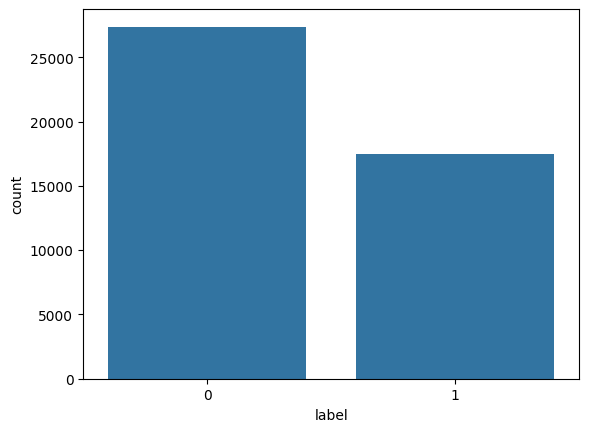

In [33]:
x = df_train.label.value_counts()
print(x)
sns.barplot(x)

In [34]:
#1. WORD-COUNT
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
print("Average word count for label 1: ", df_train[df_train['label']==1]['word_count'].mean()) 
print("Average word count for label 0: ", df_train[df_train['label']==0]['word_count'].mean()) 

#2. CHARACTER-COUNT
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
print("Average character count for label 1: ", df_train[df_train['label']==1]['char_count'].mean()) 
print("Average character count for label 0: ", df_train[df_train['label']==0]['char_count'].mean()) 

#3. UNIQUE WORD-COUNT
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
print("Average unique character count for label 1: ", df_train[df_train['label']==1]['unique_word_count'].mean()) 
print("Average unique character count for label 0: ", df_train[df_train['label']==0]['unique_word_count'].mean()) 

Average word count for label 1:  329.3989826827456
Average word count for label 0:  418.2831463958204
Average character count for label 1:  2009.2924501343086
Average character count for label 0:  2348.503890979504
Average unique character count for label 1:  169.36909184431616
Average unique character count for label 0:  199.85864601220268


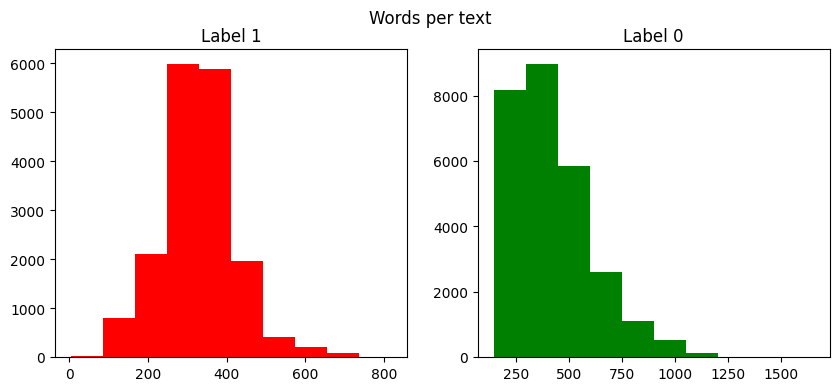

In [35]:
#Plotting word-count per tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['label']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Label 1')
train_words=df_train[df_train['label']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Label 0')
fig.suptitle('Words per text')
plt.show()

In [36]:
df_train.head()

,text,label,prompt_name,source,RDizzl3_seven,clean_text,word_count,char_count,unique_word_count
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,phone modern human today always phone always p...,379,2029,212
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,essay explain driver able use electronic devic...,366,2141,183
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,drive use cellular device today society though...,178,1044,112
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,phone drive driver able use phone operate vehi...,212,1243,117
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,cell phone operation drive ability stay connec...,332,1911,201


# Pre-processing

Here you can find a text pre-processing pipeline. We will remove any unnecessary characters and (re)format the text on demand. This can be important if we want to make the texts completely identic from a structural point of view. Stemming, lemmatization and stopword removal is also possible. We will be able to compare results with and without pre-processing.

In [4]:
"""
Strip the texts from upper and lower case, special characters, etc.
"""

def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text

#3. LEXICON-BASED TEXT PROCESSING EXAMPLES
 
#1. STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#2. STEMMING
 
# Initialize the stemmer
snow = SnowballStemmer('english')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)

#3. LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
# Full list is available here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

#FINAL PREPROCESSING
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

In [5]:
text = df_train.text.iloc[0]
print(text)
text=preprocess(text)
print(text)  #text is a string

text=stopword(text)
print(text)

text=stemming(text)
print(text)

text = lemmatizer(text)
print(text)


Phones

Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving. They are some really bad consequences when stuff happens when it comes to a phone. Some certain areas in the United States ban phones from class rooms just because of it.

When people have phones, they know about certain apps that they have .Apps like Facebook Twitter Instagram and Snapchat. So like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages. People always have different ways how to communicate with a phone. Phones have changed due to our generation.

Driving is one of the way how to get around. People always be on their phones while doing it. Which can cause serious Problems. That's why there's a thing that's called no texting while driving. That's a really important thing to remember. S

Apply pre-processing and save to a different data frame

In [6]:
# df_train_preproc = df_train.copy()
df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))
# df_train=df_train.drop(columns=['word_count','char_count','unique_word_count'])
df_train.head()

,text,label,prompt_name,source,RDizzl3_seven,clean_text
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,phone modern human today always phone always p...
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,essay explain driver able use electronic devic...
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,drive use cellular device today society though...
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,phone drive driver able use phone operate vehi...
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,cell phone operation drive ability stay connec...


In [40]:
# This cell can run for a very long time! Use it on your own responsibility:)

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

run = 0

if run:
    df_train['word_density'] = df_train['char_count'] / (df_train['word_count']+1)
    df_train['punctuation_count'] = df_train['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
    df_train['title_word_count'] = df_train['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
    df_train['upper_case_word_count'] = df_train['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
    pos_family = {
        'noun' : ['NN','NNS','NNP','NNPS'],
        'pron' : ['PRP','PRP$','WP','WP$'],
        'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
        'adj' :  ['JJ','JJR','JJS'],
        'adv' : ['RB','RBR','RBS','WRB']
    }

    df_train['noun_count'] = df_train['text'].apply(lambda x: check_pos_tag(x, 'noun'))
    df_train['verb_count'] = df_train['text'].apply(lambda x: check_pos_tag(x, 'verb'))
    df_train['adj_count'] = df_train['text'].apply(lambda x: check_pos_tag(x, 'adj'))
    df_train['adv_count'] = df_train['text'].apply(lambda x: check_pos_tag(x, 'adv'))
    df_train['pron_count'] = df_train['text'].apply(lambda x: check_pos_tag(x, 'pron'))

In [37]:
save_name = 'daigt_v2_train_preproc_v2.2.csv'

df_train.to_csv(save_name)